In [1]:
from imldiff.comparers import DifferenceComparer
from imldiff.model import Model
from imldiff.plots import plot_decision_boundaries
from imldiff.toy_examples.explainers import SHAPExplainer
from imldiff.util import printmd
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
feature_names = ['x1', 'x2']

In [3]:
class Classifier(Model):
    def predict_proba(self, X):
        X = np.asarray(X)
        return np.array([1.0 if x[0] < 0.0 else 0.0 for x in X])

class ModifiedClassifier(Model):
    def predict_proba(self, X):
        X = np.asarray(X)
        return np.array([1.0 if x[0] < 0.1 else 0.0 for x in X])

In [4]:
number_of_samples = 1000
X = np.random.uniform(-1, 1, (number_of_samples, 2))
classifier = Classifier()
modified_classifier = ModifiedClassifier()
models = [classifier, modified_classifier]

In [5]:
predictions_a = classifier.predict_proba(X)
predictions_b = modified_classifier.predict_proba(X)
predictions = np.array([b - a for a, b in zip(predictions_a, predictions_b)])

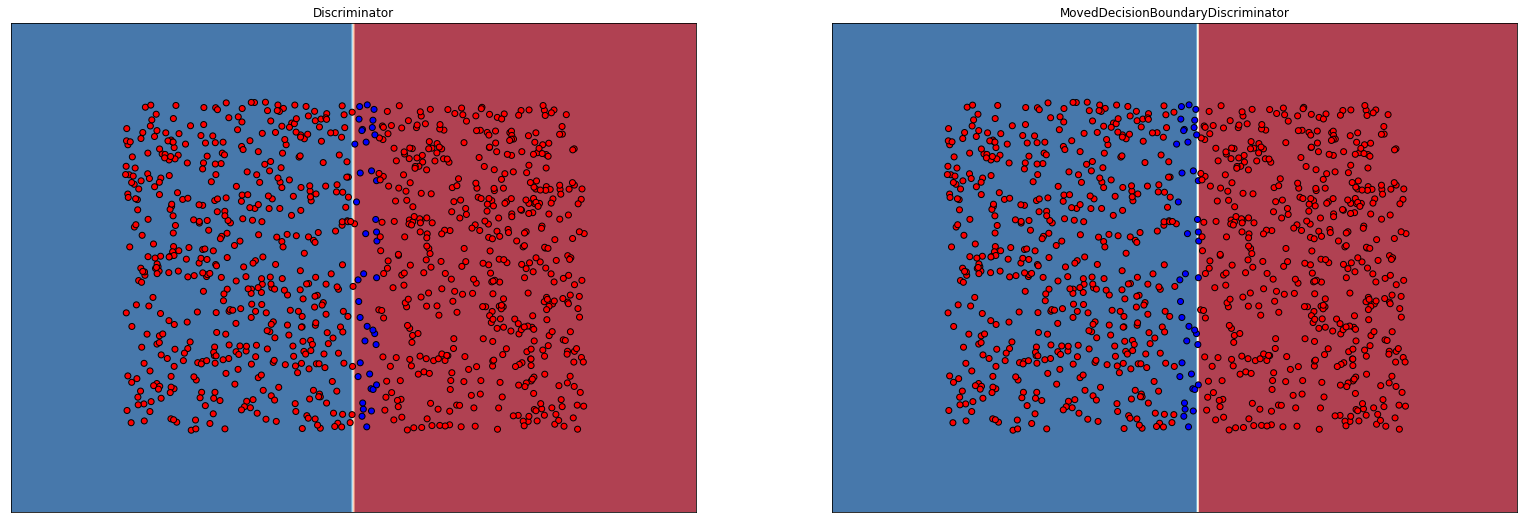

In [6]:
plot_decision_boundaries(models, X, predictions)

In [7]:
comparer = DifferenceComparer(classifier, modified_classifier)

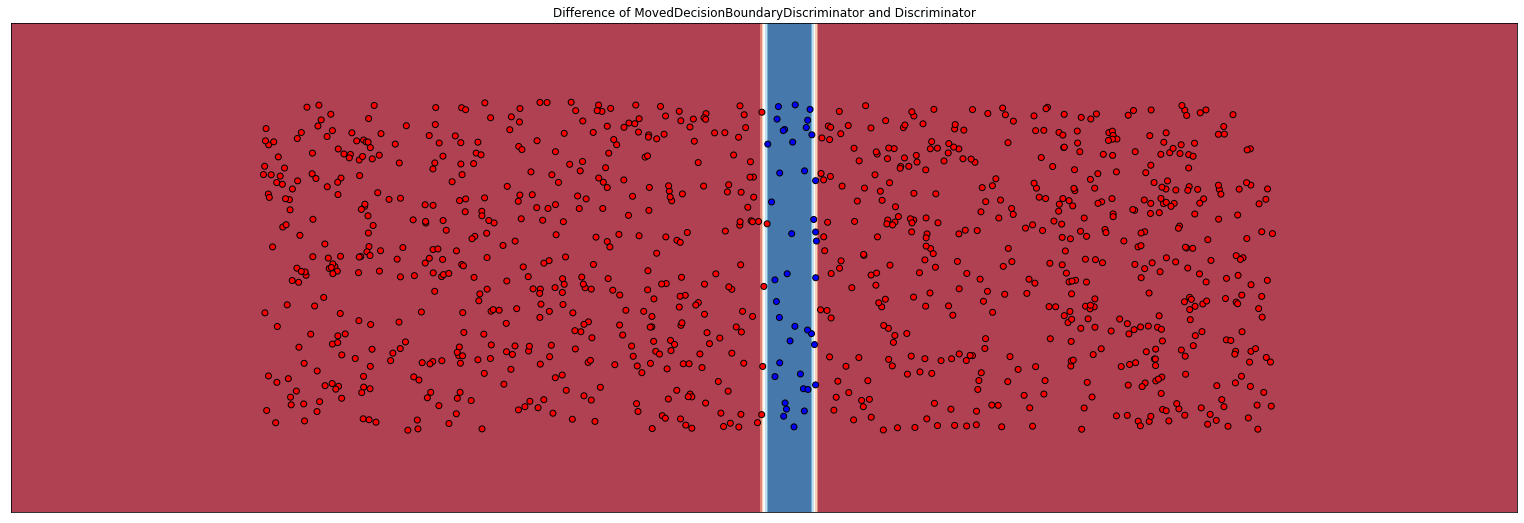

In [8]:
plot_decision_boundaries([comparer], X, predictions)

In [9]:
explainer = SHAPExplainer('Move Decision Boundary')
explainer.load_or_generate(comparer.predict_proba, X, feature_names=feature_names)

Exact explainer: 1001it [00:18, 34.70it/s]                          


Finished generating: explanations/Move Decision Boundary.exp (0:00:18.401952)


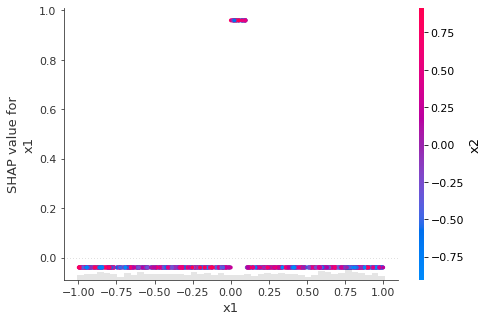

In [10]:
shap.plots.scatter(explainer.shap_values[:, 'x1'], color=explainer.shap_values)

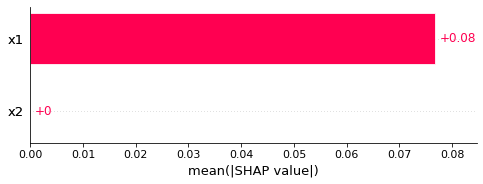

In [11]:
shap.plots.bar(explainer.shap_values)

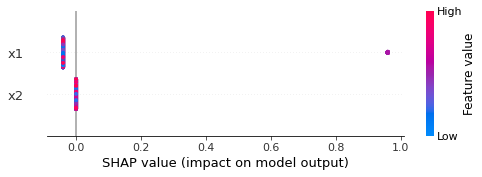

In [12]:
shap.plots.beeswarm(explainer.shap_values)

In [13]:
shap.initjs()
shap.plots.force(
    base_value=explainer.shap_values.abs.mean(0).base_values,
    shap_values=explainer.shap_values.values,
    features=explainer.shap_values.display_data,
    feature_names=feature_names)

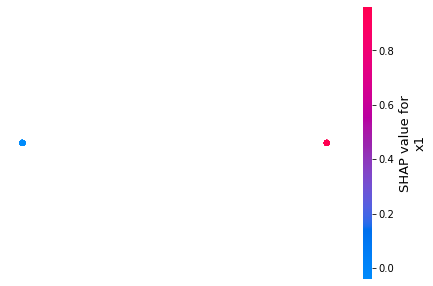

In [14]:
shap.plots.embedding('x1', explainer.shap_values.values, feature_names=feature_names)

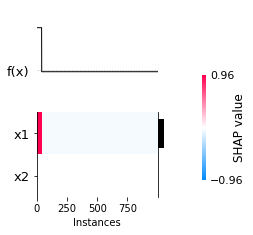

In [15]:
shap.plots.heatmap(explainer.shap_values, max_display=len(feature_names))